In [1]:
import requests
import pandas as pd
from scipy.stats import pearsonr

In [2]:
start_date = '2021-05-11'
end_date = '2024-12-09'

api_url = f"https://api.coindesk.com/v1/bpi/historical/close.json?start={start_date}&end={end_date}"
response = requests.get(api_url)

if response.status_code == 200:
    bitcoin_data = response.json().get('bpi', {})
    print(f"Retrieved {len(bitcoin_data)} records of Bitcoin prices.")
    
    # Write data to CSV
    with open('bitcoin_data.csv', 'w') as f:
        f.write('Date,Price\n')
        for date, price in bitcoin_data.items():
            f.write(f"{date},{price}\n")
    
    print("Bitcoin data has been saved to 'bitcoin_data.csv'.")
else:
    print(f"Failed to retrieve data: {response.status_code}")

Retrieved 1305 records of Bitcoin prices.
Bitcoin data has been saved to 'bitcoin_data.csv'.


In [3]:
bitcoin_prices = pd.read_csv('bitcoin_data.csv')

In [4]:
bitcoin_prices

,Date,Price
0,2021-05-11,56573.5555
1,2021-05-12,52147.8212
2,2021-05-13,49764.1321
3,2021-05-14,50032.6931
4,2021-05-15,47885.6253
...,...,...
1300,2024-12-05,96214.7599
1301,2024-12-06,100511.8591
1302,2024-12-07,99699.9566
1303,2024-12-08,100007.5219


<Axes: title={'center': 'Bitcoin Prices Over Time'}, xlabel='Date'>

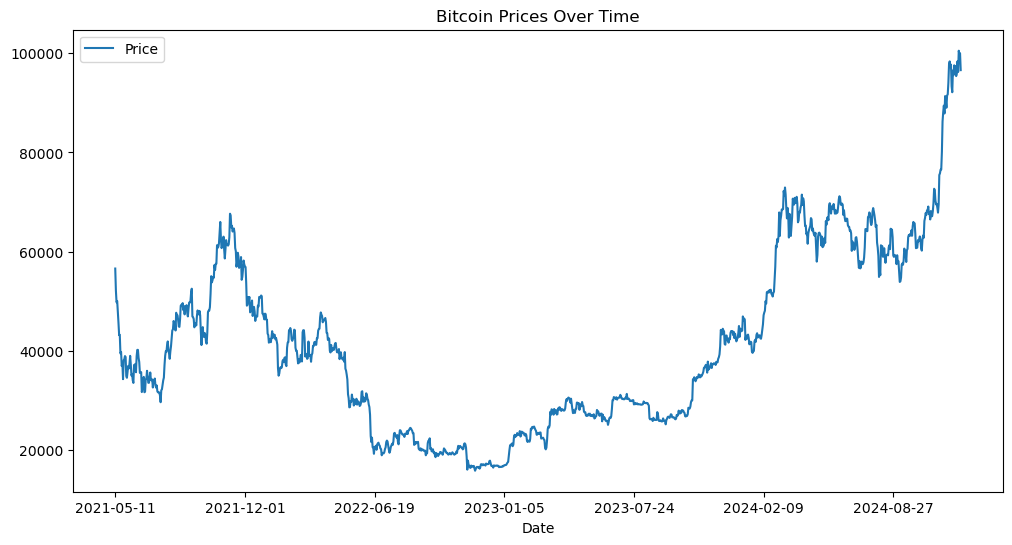

In [5]:
bitcoin_prices.plot(x='Date', y='Price', title='Bitcoin Prices Over Time', figsize=(12, 6))


In [6]:
bitcoin_prices['Return_D1'] = bitcoin_prices['Price'].shift(-1) / bitcoin_prices['Price'] - 1
bitcoin_prices['Return_W1'] = bitcoin_prices['Price'].shift(-7) / bitcoin_prices['Price'] - 1
bitcoin_prices['Return_M1'] = bitcoin_prices['Price'].shift(-30) / bitcoin_prices['Price'] - 1
bitcoin_prices['Return_Q1'] = bitcoin_prices['Price'].shift(-90) / bitcoin_prices['Price'] - 1
bitcoin_prices['Return_Y1'] = bitcoin_prices['Price'].shift(-365) / bitcoin_prices['Price'] - 1

In [7]:
bitcoin_prices

,Date,Price,Return_D1,Return_W1,Return_M1,Return_Q1,Return_Y1
0,2021-05-11,56573.5555,-0.078230,-0.236462,-0.351021,-0.187060,-0.449361
1,2021-05-12,52147.8212,-0.045710,-0.243703,-0.283928,-0.126006,-0.423128
2,2021-05-13,49764.1321,0.005397,-0.201110,-0.283517,-0.079793,-0.391688
3,2021-05-14,50032.6931,-0.042913,-0.262047,-0.222617,-0.119001,-0.421418
4,2021-05-15,47885.6253,-0.047635,-0.217073,-0.161287,-0.004822,-0.371043
...,...,...,...,...,...,...,...
1300,2024-12-05,96214.7599,0.044662,NaN,NaN,NaN,NaN
1301,2024-12-06,100511.8591,-0.008078,NaN,NaN,NaN,NaN
1302,2024-12-07,99699.9566,0.003085,NaN,NaN,NaN,NaN
1303,2024-12-08,100007.5219,-0.034094,NaN,NaN,NaN,NaN


In [8]:
bitcoin_returns_classified = bitcoin_prices[['Return_D1', 'Return_W1', 'Return_M1', 'Return_Q1', 'Return_Y1']].applymap(
    lambda x: 0 if x > 0 else (1 if x < 0 else 2)
)

In [10]:
def analyze_bitcoin_sentiment_correlation(dates, sentiment_scores):
    """
    Performs Pearson correlation analysis between sentiment scores and Bitcoin returns.

    Parameters:
    - dates (list of str): List of dates in 'YYYY-MM-DD' format.
    - sentiment_scores (list of int): Corresponding sentiment scores (-1, 0, 1).

    Returns:
    - dict: Correlation coefficients for next day, next week, next month, next quarter, and next year returns.
    """
    if len(dates) != len(sentiment_scores):
        print("Error: The number of dates and sentiment scores must be equal.")
        return

    # Create DataFrame from dates and sentiment scores
    sentiment_df = pd.DataFrame({
        'Date': dates,
        'Sentiment': sentiment_scores
    })

    # Merge with bitcoin_prices DataFrame on Date
    merged_df = pd.merge(sentiment_df, bitcoin_prices, on='Date', how='inner')

    if merged_df.empty:
        print("No overlapping data between sentiment and bitcoin prices.")
        return

    # Compute Pearson correlation for each return period without dropping NaNs globally
    correlations = {}
    return_periods = {
        'Return_D1': 'Next Day',
        'Return_W1': 'Next Week',
        'Return_M1': 'Next Month',
        'Return_Q1': 'Next Quarter',
        'Return_Y1': 'Next Year'
    }

    for period, label in return_periods.items():
        # Select relevant columns and drop NaNs for the current period
        df_period = merged_df[['Sentiment', period]].dropna()
        if not df_period.empty:
            corr, _ = pearsonr(df_period['Sentiment'], df_period[period])
            correlations[period] = corr
        else:
            correlations[period] = None

    # Print the results
    print("Correlation Results:")
    for period, label in return_periods.items():
        corr_value = correlations[period]
        if corr_value is not None:
            print(f"{label}: {corr_value:.4f}")
        else:
            print(f"{label}: No data")
    
# Example usage:
# dates = ["2021-05-11", "2021-05-12", ...]
# sentiment_scores = [1, -1, ...]
# analyze_bitcoin_sentiment_correlation(dates, sentiment_scores)


In [12]:
# Placeholder test data
test_dates = [
    "2021-05-11",
    "2021-05-12",
    "2021-05-13",
    "2021-05-14",
    "2021-05-15"
]
test_sentiment_scores = [1, -1, 0, 1, -1]


In [17]:

# Call the analysis function
correlation_results = analyze_bitcoin_sentiment_correlation(test_dates, test_sentiment_scores)


Correlation Results:
Next Day: -0.2315
Next Week: -0.3989
Next Month: -0.4479
Next Quarter: -0.6525
Next Year: -0.6300
